In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

ye aabhi preprocessing chal rahi hai . taki baad mein koe dikkat na ho jaye .
kabhi model dikkat karne lage data set ki vajah se ya bottle necj effect ki vjh se aur auski accuracy ka baja baj jaye


In [4]:

# eske through maine data set ko load kiya hai . mere har ek batch mein ek 32 images hain
# image ka size define kar diya haia
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = '/content/drive/MyDrive/dataset'
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)


Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [5]:
# um ek technique use karenge prefetch naam ki jo ki hume data ko harddisk se load hite hue hone vale bottleneck effect se bachati hai
AUTOTUNE = tf.data.experimental.AUTOTUNE # ye automatically system ko dekh kar bata deta hai ki tkitne batches prefetch ko lene chahiye
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) # ye buffer_size=AUTOTUNE etne batches ko train_dataset se kheech lega .
# story jab GPU data ko process kae raha hoga tab CPU AUTOTUNE etne bathes ko ready rakhega GPU ke liye . taki time waste na ho aur koe bottle neck effect an aaye

# better samaghme ke liye refer to the video number 45 of codehelp deep learning .

In [6]:
# aab hum data augementation karenge taaki aapne existing data ko versatile bana sake
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal")) # .add() it helps to add sequential layers to the model
    data_augmentation.add(RandomRotation(0.2))
    return data_augmentation # sequentioal model having 2 layers . onr for random flio another for random rotation

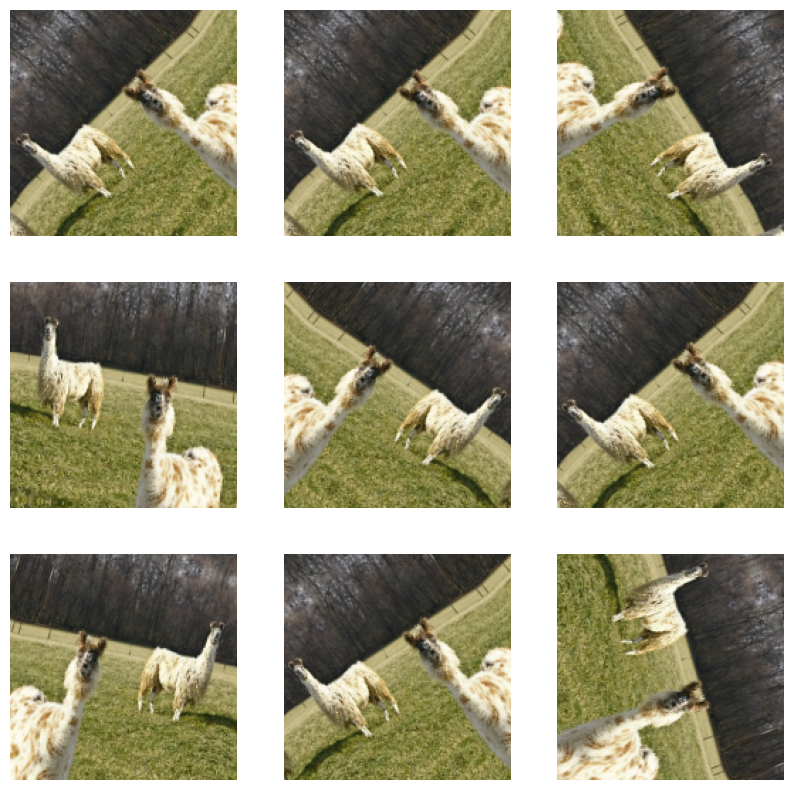

In [7]:
data_augmentation = data_augmenter()
# maine kya kiya ki data augmentation  laga diya hai jisse ki aap dekho ki images kaisi hogayi hai
# ye model ko help karega ki vo apne weights and bias ko mast set kar le images ke hisab se
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# aupar val afunction model ko suitable bana deta hai ki ause mobilenetv2 use kar sake

In [35]:
def model (image_shape = IMG_SIZE, data_augmentation = data_augmenter()) :
  input_shape = image_shape + (3,)
  base_model = tf.keras.applications.MobileNetV2(input_shape= input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
  base_model.trainable = False
  inputs = tf.keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tfl.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(0.2)(x)
  #prediction_layer = tfl.Dense(2)
  prediction_layer = tfl.Dense(2)
  prediction_layer = tfl.Dense(1)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  return model

In [36]:
model2 = model(IMG_SIZE, data_augmentation)

model with no learning  rate decay and fine tuning


In [38]:
learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 299ms/step - loss: 0.6967 - accuracy: 0.5878 - val_loss: 0.6218 - val_accuracy: 0.6308
Epoch 2/5
9/9 [==============================] - 4s 196ms/step - loss: 0.5340 - accuracy: 0.7061 - val_loss: 0.5640 - val_accuracy: 0.6154
Epoch 3/5
9/9 [==============================] - 3s 96ms/step - loss: 0.5106 - accuracy: 0.7214 - val_loss: 0.4606 - val_accuracy: 0.7231
Epoch 4/5
9/9 [==============================] - 3s 95ms/step - loss: 0.4688 - accuracy: 0.7595 - val_loss: 0.3918 - val_accuracy: 0.7846
Epoch 5/5
9/9 [==============================] - 3s 96ms/step - loss: 0.4115 - accuracy: 0.7786 - val_loss: 0.3612 - val_accuracy: 0.7692


In [40]:
model2.history

In [41]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

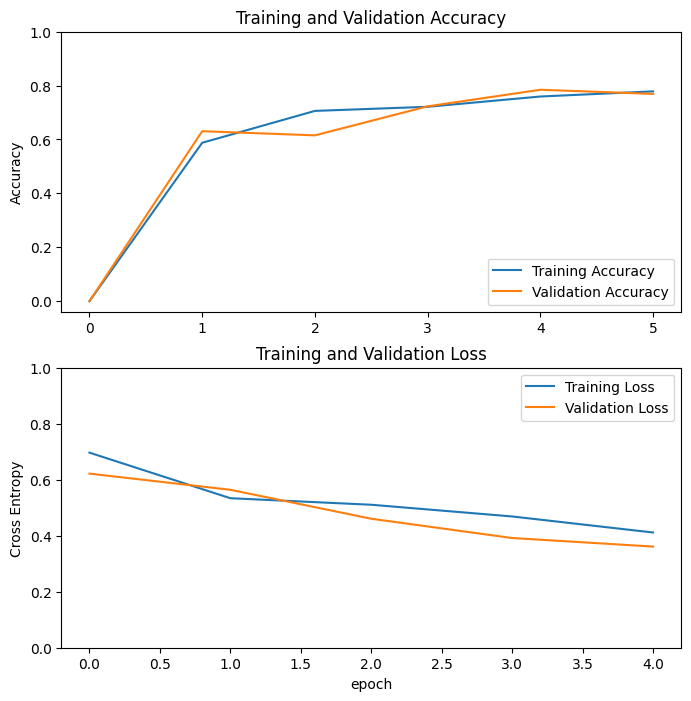

In [42]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
print(acc) # 77 % aayi h , bekar hai . aab learning rate decay use kiya hai .

[0.0, 0.5877862572669983, 0.7061068415641785, 0.7213740348815918, 0.7595419883728027, 0.7786259651184082]


Learning rate decay use karra hoon .
taki accuracy badh sake .
achived a accuracy of 98% on validation score

In [48]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [55]:
learning_rate = 0.001
initial_learning_rate = learning_rate
decay_steps = 6
decay_rate = 0.95

In [56]:
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

In [57]:
model2.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [58]:
initial_epochs = 9
history = model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs
)

Epoch 1/9
9/9 [==============================] - 7s 200ms/step - loss: 0.2227 - accuracy: 0.9313 - val_loss: 0.1256 - val_accuracy: 0.9385
Epoch 2/9
9/9 [==============================] - 3s 96ms/step - loss: 0.1822 - accuracy: 0.9351 - val_loss: 0.1185 - val_accuracy: 0.9538
Epoch 3/9
9/9 [==============================] - 4s 102ms/step - loss: 0.1975 - accuracy: 0.9313 - val_loss: 0.1310 - val_accuracy: 0.9385
Epoch 4/9
9/9 [==============================] - 3s 95ms/step - loss: 0.1908 - accuracy: 0.9351 - val_loss: 0.1196 - val_accuracy: 0.9538
Epoch 5/9
9/9 [==============================] - 3s 97ms/step - loss: 0.2121 - accuracy: 0.9122 - val_loss: 0.1112 - val_accuracy: 0.9692
Epoch 6/9
9/9 [==============================] - 3s 99ms/step - loss: 0.1932 - accuracy: 0.9237 - val_loss: 0.1123 - val_accuracy: 0.9692
Epoch 7/9
9/9 [==============================] - 4s 196ms/step - loss: 0.1725 - accuracy: 0.9046 - val_loss: 0.1084 - val_accuracy: 0.9692
Epoch 8/9
9/9 [================

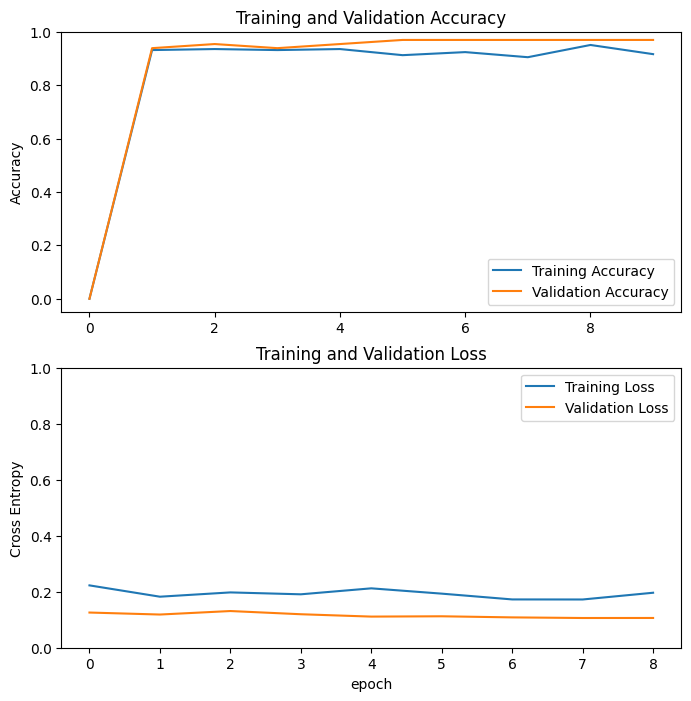

In [59]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

aab hum fine tuning with learning rate decay try kar sakte hain .

In [65]:
lr_schedule1 = ExponentialDecay(
    initial_learning_rate*0.1,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

In [66]:
base_model = model2.layers[4]
base_model.trainable = True
fine_tune_at = 122
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule1)
metrics=['accuracy']
model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [67]:
history_fine = model2.fit(train_dataset,
                         epochs= 18,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 9/18
9/9 [==============================] - 13s 235ms/step - loss: 0.4540 - accuracy: 0.8473 - val_loss: 0.2296 - val_accuracy: 0.8308
Epoch 10/18
9/9 [==============================] - 3s 103ms/step - loss: 0.2343 - accuracy: 0.9084 - val_loss: 0.2437 - val_accuracy: 0.8154
Epoch 11/18
9/9 [==============================] - 3s 154ms/step - loss: 0.2448 - accuracy: 0.8969 - val_loss: 0.3039 - val_accuracy: 0.8154
Epoch 12/18
9/9 [==============================] - 3s 101ms/step - loss: 0.2118 - accuracy: 0.8969 - val_loss: 0.1040 - val_accuracy: 0.9846
Epoch 13/18
9/9 [==============================] - 3s 103ms/step - loss: 0.1608 - accuracy: 0.9275 - val_loss: 0.0863 - val_accuracy: 0.9692
Epoch 14/18
9/9 [==============================] - 3s 101ms/step - loss: 0.0946 - accuracy: 0.9733 - val_loss: 0.0720 - val_accuracy: 0.9692
Epoch 15/18
9/9 [==============================] - 4s 122ms/step - loss: 0.1344 - accuracy: 0.9313 - val_loss: 0.0595 - val_accuracy: 1.0000
Epoch 16/18
9

In [68]:
accuracy = [0.] + history_fine.history['accuracy']

In [69]:
print(accuracy)

[0.0, 0.847328245639801, 0.9083969593048096, 0.8969465494155884, 0.8969465494155884, 0.927480936050415, 0.9732824563980103, 0.9312977194786072, 0.9503816962242126, 0.9541984796524048, 0.9885495901107788]


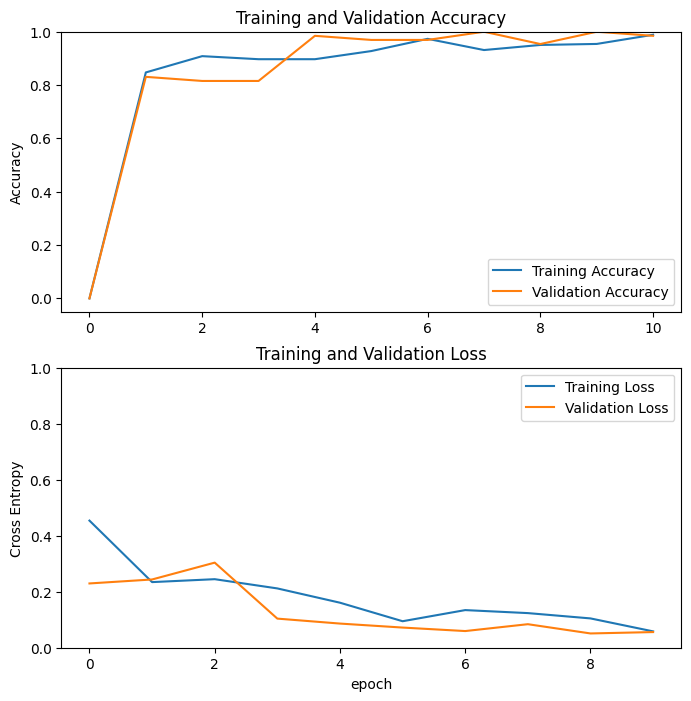

In [71]:

val_acc = [0.] + history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [73]:
train_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [79]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
target_size = (160, 160)
def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array
test_image_path = '/content/drive/MyDrive/OIP.jpg'
test_image = load_and_preprocess_image(test_image_path, target_size)
predictions = model2.predict(test_image)
predicted_probability = tf.nn.sigmoid(predictions[0]).numpy()
print("Predicted Probability:", predicted_probability)
predicted_class = 1 if predicted_probability > 0.5 else 0
print("Predicted Class:", predicted_class)

1/1 [==============================] - 1s 1s/step
Predicted Probability: [0.82315314]
Predicted Class: 1
